In [14]:
# this model includes ql
# it uses instantaneous bedrock erosion rate to calc ql
# it uses gamma to represent fraction of plucked material that becomes coarse gravel
# it uses theta to represent fraction of hillslope material that enters fluvial system as coarse 
## (maybe this should be same as gamma, 
## since the real fxn of this parameter is to tell us 
## how much coarse stuff is available for bedload transport/abrasion)

# potential updates: see if adding weighted average back in to ql calculation still allows for stability
## update on the update: this led to stability issues, and it's not worth the time now trying to debug, 
## so just stick with using instantaneous erosion rate. 
## Most interested in steady state profiles anyway, so this is fine.

In [15]:
import numpy as np
import matplotlib.pyplot as plt

In [16]:
# create a profile
dx = 500
x = np.arange(0, 50000, dx)
x_node = x + (dx/2)

# add some elevation
Hstar = 0.5 # depth decay
etab = np.zeros(len(x)) # bedrock elevation
etab[:] = np.linspace(1, 0.1, len(x)) # need to start with slight bedrock slope
H = Hstar + np.zeros(len(x)) # alluvium thickness
eta = etab + H # topography

In [17]:
# define constants and other parameters
K = 2.5e-7 # erodibility
beta = 0.0005 # abradability
r = 5. # runoff rate
U = 0.0001 # uplift or baselevel fall rate
I = 0.01 # intermittency
phi = 0.1 # porosity
D = 0.01 # grain size
gamma = 0.5 # fraction plucked that becomes coarse
theta = 0.5 # fraction hillslope that enters as coarse
# treat as same!!! Point is what fraction becomes coarse
# so just be sure to change these together

kqs = 0.041 # sed transport coeff
kxb = 25 # valley width coeff
Pxb = 1./5. # valley width exp
kb = 8.3e-8 # channel width coeff

B_valley = kxb * (x_node**Pxb) # valley width
# Q = (r * kxb * x_node**(1 + Pxb))/(1 + Pxb) # discharge
A = (1./3.) * (x**2)
Q = r * A

In [18]:
def model(x, dx, x_node,
          K, beta, gamma, theta,
          D, phi, Hstar,
          kb, kqs, I, r, U,
          etab, H, eta,
          B_valley, Q,
          num_steps = 1):
    
    q = Q/B_valley
    dt = 50
    
    run_duration = dt * num_steps
    cum_time = 0.0
    
    Qs = np.zeros(len(x))
    qs = np.zeros(len(x))
    Eb_p = np.zeros(len(x))
    Eb_a = np.zeros(len(x))
    Eb = np.zeros(len(x))
    Eh = np.zeros(len(x))
    E = np.zeros(len(x))
    ql = np.zeros(len(x)) # lateral sediment supply
    
    H[-1] = 0
    E[-1] = U
    q[0] = 0
    Qs[0] = 0
    
    while cum_time < run_duration:
        
        # drop baselevel
        eta[-1] -= U * dt
        
        # set boundary conditions
        etab[-1] = eta[-1]
        
        # calc slope
        S = -np.diff(eta)/dx
        
        # calc bed exposure
        alpha = np.exp(-H/Hstar)
        
        # calc sed transport
        Qs[1:] = kqs * I * Q[1:] * S**(7./6.) * (1 - alpha[:-1])
        qs[1:] = Qs[1:] / B_valley[1:]
        
        # calc bedrock erosion
        Eb_p[:-1] = K * Q[1:] * S**(7./6.) * alpha[:-1] * gamma
        Eb_a[:-1] = beta * Qs[1:] * alpha[:-1]
        Eb[:-1] = (Eb_p[:-1] + Eb_a[:-1]) / B_valley[:-1]
        
        # calc lateral flux
        ql[:-1] = ((Eb[:-1] * theta)/beta) * (1 - np.exp(-beta * x[1:]/3))
        
        # calc grain attrition
        atr = Qs * beta
        
        # calc sediment erosion rate
        Eh[:-1] = 1/((1 - phi) * B_valley[:-1]) * (np.diff(Qs)/dx + atr[1:] - Eb_p[:-1] - ql[:-1])
        
        # calc total erosion rate
        E[:-1] = Eb[:-1] + Eh[:-1]
        
        # update topography
        etab[:-1] -= Eb[:-1] * dt
        H[:-1] -= Eh[:-1] * dt
        H[H<0] = 0
        eta[:-1] = etab[:-1] + H[:-1]
        
        # update elapsed time
        cum_time += dt
        
    print(cum_time)
        
    return (dt, S, q, alpha, Qs, qs, Eb_p, Eb_a, Eb, ql, atr, Eh, E, etab, H, eta)

In [19]:
#now write a test
num_steps = 700000

test_run = [x, dx, x_node, 
            K, beta, gamma, theta,
            D, phi, Hstar,
            kb, kqs, I, r, U,
            etab, H, eta,
            B_valley, Q,
            num_steps]

# and run it
(dt, S, q, alpha, Qs, qs, Eb_p, Eb_a, Eb, ql, atr, Eh, E, etab, H, eta) = model(*test_run)

35000000.0


In [20]:
Eb

array([1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 0.e+00])

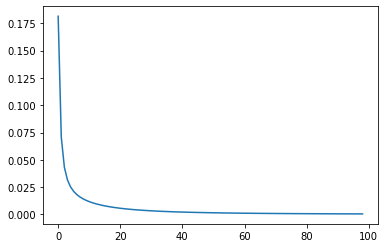

In [21]:
plt.plot(S)

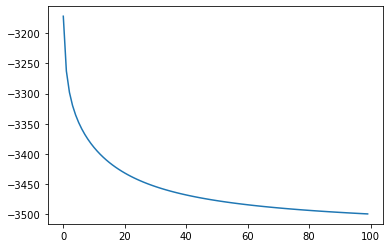

In [22]:
plt.plot(eta)

In [23]:
S[-1]

0.0005194448017227842

In [24]:
eta

array([-3171.70937098, -3262.46415248, -3297.92293745, -3319.51602526,
       -3335.28997114, -3347.88138859, -3358.43786405, -3367.55724359,
       -3375.59200145, -3382.76947207, -3389.24651438, -3395.13712518,
       -3400.52758193, -3405.48531445, -3410.06439435, -3414.30909149,
       -3418.25627037, -3421.93706061, -3425.3780564 , -3428.6022002 ,
       -3431.62944889, -3434.47728594, -3437.16112237, -3439.69461545,
       -3442.08992555, -3444.35792575, -3446.50837473, -3448.55006068,
       -3450.49092231, -3452.33815112, -3454.09827867, -3455.77725137,
       -3457.38049501, -3458.91297064, -3460.37922326, -3461.78342439,
       -3463.12940939, -3464.42071042, -3465.66058548, -3466.85204417,
       -3467.99787065, -3469.10064399, -3470.16275648, -3471.18642991,
       -3472.17373022, -3473.12658074, -3474.046774  , -3474.93598249,
       -3475.79576832, -3476.62759205, -3477.43282057, -3478.21273444,
       -3478.96853438, -3479.70134735, -3480.41223195, -3481.10218347,
      

In [25]:
eta_adj = eta - eta[-1]

In [26]:
eta_adj

array([3.27690629e+02, 2.36935848e+02, 2.01477063e+02, 1.79883975e+02,
       1.64110029e+02, 1.51518611e+02, 1.40962136e+02, 1.31842756e+02,
       1.23807999e+02, 1.16630528e+02, 1.10153486e+02, 1.04262875e+02,
       9.88724181e+01, 9.39146856e+01, 8.93356057e+01, 8.50909086e+01,
       8.11437297e+01, 7.74629394e+01, 7.40219437e+01, 7.07977998e+01,
       6.77705512e+01, 6.49227141e+01, 6.22388777e+01, 5.97053846e+01,
       5.73100745e+01, 5.50420743e+01, 5.28916253e+01, 5.08499394e+01,
       4.89090777e+01, 4.70618489e+01, 4.53017214e+01, 4.36227487e+01,
       4.20195050e+01, 4.04870294e+01, 3.90207768e+01, 3.76165757e+01,
       3.62705907e+01, 3.49792896e+01, 3.37394146e+01, 3.25479559e+01,
       3.14021294e+01, 3.02993561e+01, 2.92372436e+01, 2.82135701e+01,
       2.72262698e+01, 2.62734193e+01, 2.53532261e+01, 2.44640176e+01,
       2.36042317e+01, 2.27724080e+01, 2.19671795e+01, 2.11872656e+01,
       2.04314657e+01, 1.96986527e+01, 1.89877681e+01, 1.82978166e+01,
      